## Kiefer Wolfowitz Algorithm with a Burn Period

### Let $a_n = n^{-1}$ and $c_n =  n^{-1/3}$ for $n \geq 1$.
### In step $k$, fix price $p_k$, and run 2 batches of $C$ customers each with price $p_k + c_k$ and $p_k - c_k$
### Evaluate $p_{k+1} = p_k + a_k \bigg(\frac{N(p_k+c_k) - N(p_k-c_k)}{2c_k}\bigg)$

### Before every measurement $N(p)$ with price $p$, the system is allowed to attain stationarity
### This is achieved by letting the system run for a duration $b_p$ with price $p$ before measuring $N(p)$

In [1]:
import math

import numpy as np

from scipy.optimize import fsolve, minimize, Bounds, LinearConstraint
from scipy.integrate import quad
from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape

import matplotlib.pyplot as plt
from matplotlib import cm

from collections import deque

import time

In [2]:
# Important variables

# True arrival rate
global lam

# True joining probability parameters
global theta_1, theta_2

# Number of servers
global s

# Admission price - what we control
global price

# Total customers that we shall generate
global n

In [3]:
def generate_arrival_process(x): # x is the arrival rate
    global interarrival_times
    global arrival_times
    
    interarrival_times = np.random.exponential(1/x, n)
    arrival_times = np.cumsum(interarrival_times)

In [4]:
def generate_service_times(x): # x is the mean service time
    global service_times
    global mean_service_time
    
    # Gamma distribution - mean = x[0]x[1] and variance = x[0]x[1]^2
    # mean_service_time = x[0]*x[1]
    # service_times = np.random.gamma(x[0], x[1], n)
    
    # Exponential distribution
    mean_service_time = x
    service_times = np.random.exponential(x, n)

In [5]:
class Customer(): # Creating an object "Customer" with relevant information
    # Price paid by customer
    price_paid = 0
    
    # Time of arrival
    t_arrival = 0
    
    # Time of departure
    t_departure = 0
    
    # Time taken for servicing
    t_service = 0
    
    # Time spent waiting in queue (does not include service time)
    t_in_queue = 0
    
    # Server number which served the customer
    server = 0
    
    # Does the customer balk? 0 if yes, 1 if no
    balking = 0
    
    # Customer number (assigned between 0 and n-1)
    number = 0
    
    # Observed number of customers in system upon arrival and before joining
    observed_system_occupancy = 0
    
    jump_virtual_waiting_time = 0

In [6]:
def queue_simulation_burn_period(price, bp, ws):
    
# Idea

# Create array of workload of servers - Workload[s]
# Calculate min workload and server with min workload. If min workload > incoming customer patience, then customer balks. 
# Else, new workload (of min workload server) = current workload + service time of incoming customer
# This array will be updated during every arrival (only based on updated values we can decide balking or not!)
# If customer is non-balking, it is easy to get their waiting time in queue (= min workload amongst all servers)

# Maintain an array of "s" queues, each queue i literally represents queue in front of server i - append and pop customers during each arrival event
# Maintain a list to keep track of residual service times
    
    # Simulation variables
    global customers
    global server_workloads
    global dynamic_queues
    global dynamic_residual_service_times
    
    # Post processing variables
    global effective_arrival_times
    global effective_interarrival_times
    global departure_times
    global waiting_times
    global upward_jump_virtual_waiting_times
    
    # Virtual waiting time - at time of joining
    global virtual_waiting_time_balking_instances
    global virtual_waiting_time_non_balking_instances
    global estimated_virtual_waiting_time_balking_instances
    global estimated_virtual_waiting_time_non_balking_instances
    
    # Queue length - at time of joining
    global system_size_balking_instances
    global system_size_non_balking_instances
    global price_non_balking_instances
    
    global gamma
    
    global prices_list_burn
    
##################################################################################################################################    
    
    # Initialization
    customers = [Customer() for i in range(n)]
    server_workloads = np.zeros(s)
    
    virtual_waiting_time_balking_instances = []
    virtual_waiting_time_non_balking_instances = []
    
    estimated_virtual_waiting_time_balking_instances = []
    estimated_virtual_waiting_time_non_balking_instances = []
    
    system_size_balking_instances = []
    system_size_non_balking_instances = []
    
    price_non_balking_instances = []
    
    # New variables to keep track of
    dynamic_residual_service_times = np.zeros(s) # Keeps track of residual service times just after arrival events during the simulation
    dynamic_queues = [] # Maintains queues corresponding to all s servers
    for i in range(s):
        q = deque()
        dynamic_queues.append(q)

    # Relevant information to calculate and store
    effective_arrival_times = []
    effective_interarrival_times = []
    departure_times = []
    waiting_times = []
    upward_jump_virtual_waiting_times = []
    
    prices_list_burn = []
    prices_list_burn.append(price)
    
    # R1 stores empirical revenue for one day at price p-c
    # R2 stores empirical revenue for one day at price p+c
    # time keeps track of integral time
    R1 = 0
    R2 = 0
    time = 0
    batch = 1
    
    gamma = 1
    
    a = gamma
    c = 1
    
    window_size = ws
    
    burn_period = bp # Before making any observation, we allow a burn time with same price where nothing is recorded.
##################################################################################################################################   

    i = 0
    for cust in customers:
        # Once two days end, we update price and move to next batch
        if arrival_times[i] > time + 2*burn_period + 2*window_size:
            
            R1 = R1/window_size
            R2 = R2/window_size
            
            # Price update
            if R1 == 0 and R2 == 0:
                price = max(1, price*0.5)
            else:
                price = price + a*(R2-R1)/(2*c)
                price = max(1, price)
                prices_list_burn.append(price)
            
            # Move on to next batch, and update "a" (learning parameter) and "c"
            batch += 1
            a = gamma/batch
            c = 1/(batch**(1/3))
            
            # Update burn period and window size length
            # burn_period = bp # Constant burn period length
            burn_period = bp*(batch**0.5) # Burn period grows as batch size increases
            window_size = ws*(batch**0.5)
            
            # Reset revenues to 0
            R1 = 0
            R2 = 0
            time = time + 2*window_size + 2*burn_period
        
             
        # Storing customer information first
        cust.number = i
        cust.t_arrival = arrival_times[i]
        cust.t_service = service_times[i]
        
        # Calculates number in system observed by incoming arrival
        system_size_at_joining_instant = sum(len(dynamic_queues[j]) for j in range(s))
        estimated_virtual_waiting_time = max(0, (system_size_at_joining_instant-s+1)*mean_service_time/s)
        
        min_workload_server = server_workloads.argmin()
        prospective_waiting_time = server_workloads[min_workload_server]
        
        if arrival_times[i] < time + burn_period + window_size:
            joining_probability = np.exp(-theta_1*(price-c) -theta_2*prospective_waiting_time)
        else:
            joining_probability = np.exp(-theta_1*(price+c) -theta_2*prospective_waiting_time)
    
        decision = np.random.binomial(1, joining_probability)

        if decision == 0: # Balking customer
            cust.balking = 0 # does not join
            virtual_waiting_time_balking_instances.append(server_workloads[min_workload_server])
            system_size_balking_instances.append(system_size_at_joining_instant)
            estimated_virtual_waiting_time_balking_instances.append(estimated_virtual_waiting_time)

        else: # Non-balking customer
            if arrival_times[i] > time + burn_period and arrival_times[i] < time + burn_period + window_size:
                R1 += (price - c)
                price_non_balking_instances.append(price-c)
            elif arrival_times[i] >= time + 2*burn_period + window_size: # arrival_times[i] < time + 2*burn_period + 2*window_size holds because of first "if" condition in loop.
                R2 += (price + c)
                price_non_balking_instances.append(price+c)
            
            virtual_waiting_time_non_balking_instances.append(server_workloads[min_workload_server])
            system_size_non_balking_instances.append(system_size_at_joining_instant)
            estimated_virtual_waiting_time_non_balking_instances.append(estimated_virtual_waiting_time)
            
            dynamic_queues[min_workload_server].append(i) # Customer joins queue corresponding to minimum workload server
            if len(dynamic_queues[min_workload_server]) == 1:
                dynamic_residual_service_times[min_workload_server] = cust.t_service

            effective_arrival_times.append(cust.t_arrival)

            cust.balking = 1 # joins
            cust.server = min_workload_server
            cust.t_in_queue = server_workloads[min_workload_server]
            cust.t_departure = cust.t_arrival + cust.t_in_queue + cust.t_service

            # Jump in virtual waiting time calculation
            cust.jump_virtual_waiting_time -= server_workloads[min_workload_server] # Subtracting virtual waiting time BEFORE customer arrival
            server_workloads[min_workload_server] += cust.t_service # Adds arriving customer's service time to minimum workload server
            min_workload_server = server_workloads.argmin() # Calculates new "minimum workload server"
            cust.jump_virtual_waiting_time += server_workloads[min_workload_server] # Adding new virtual waiting time AFTER customer arrival

            waiting_times.append(cust.t_in_queue)
            departure_times.append(cust.t_departure)
            upward_jump_virtual_waiting_times.append(cust.jump_virtual_waiting_time)
        
        
        
        if i != n-1:
            # Time to update residual service times here. Mathematical formulation of the code is as follows:-
            # Suppose service times of a queue corresponding to a server are: 5(residual service time of customer being served),20,22,17,23,28,... and time since last arrival is 50,
            # Then, new queue becomes 14,23,28,... 
            for j in range(s):
                if len(dynamic_queues[j]) == 0:
                    dynamic_residual_service_times[j] = 0
                    continue

                time_until_next_arrival = arrival_times[i+1] - arrival_times[i]

                if time_until_next_arrival > dynamic_residual_service_times[j]:
                    time_until_next_arrival -= dynamic_residual_service_times[j]
                    dynamic_residual_service_times[j] = 0
                    dynamic_queues[j].popleft()
                else:
                    dynamic_residual_service_times[j] -= time_until_next_arrival
                    continue

                while len(dynamic_queues[j])!=0 and time_until_next_arrival > customers[dynamic_queues[j][0]].t_service:
                    time_until_next_arrival -= customers[dynamic_queues[j][0]].t_service
                    dynamic_queues[j].popleft()

                if len(dynamic_queues[j]) == 0:
                    dynamic_residual_service_times[j] = 0
                    continue
                else:
                    dynamic_residual_service_times[j] = customers[dynamic_queues[j][0]].t_service - time_until_next_arrival
            
            
            server_workloads -= (arrival_times[i+1] - arrival_times[i]) # Subtracting time passed until next arrival from all server workloads
            server_workloads = np.where(server_workloads < 0, 0, server_workloads)  # All those with workload < 0 are converted to 0
        
        i += 1

##################################################################################################################################
        
    # Post processing    
    effective_interarrival_times = [effective_arrival_times[0]] + [j-i for i,j in zip(effective_arrival_times, effective_arrival_times[1:])]
    departure_times.sort()
    effective_arrival_times = np.array(effective_arrival_times)
    effective_interarrival_times = np.array(effective_interarrival_times)
    departure_times = np.array(departure_times)
    waiting_times = np.array(waiting_times)
    upward_jump_virtual_waiting_times = np.array(upward_jump_virtual_waiting_times)
    
    system_size_balking_instances = np.array(system_size_balking_instances)
    system_size_non_balking_instances = np.array(system_size_non_balking_instances)
    
    virtual_waiting_time_balking_instances = np.array(virtual_waiting_time_balking_instances)
    virtual_waiting_time_non_balking_instances = np.array(virtual_waiting_time_non_balking_instances)
    
    estimated_virtual_waiting_time_balking_instances = np.array(estimated_virtual_waiting_time_balking_instances)
    estimated_virtual_waiting_time_non_balking_instances = np.array(estimated_virtual_waiting_time_non_balking_instances)

## Simulation

In [9]:
# True values
lam = 20
theta_1 = 0.1
theta_2 = 0.2
s = 5

# Simulation
n = 1000000
generate_arrival_process(lam)
generate_service_times(1)

# Queue simulation variables
start_price = 10
burn_period = 100
window_size = 1000

queue_simulation_burn_period(start_price, burn_period, window_size)

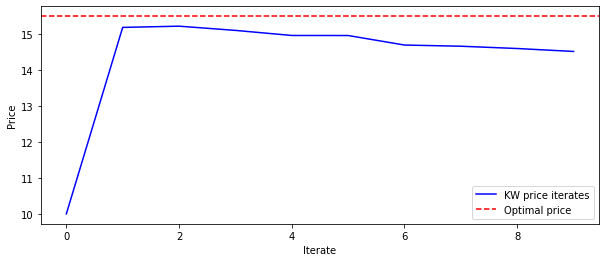

In [10]:
optimal_price = 15.5

plt.figure(figsize = (10,4))
plt.plot(prices_list_burn, color ="blue", label = "KW price iterates")
plt.axhline(y = optimal_price, color = 'red', linestyle = "dashed", label = "Optimal price")
plt.legend()
plt.xlabel("Iterate")
plt.ylabel("Price")

plt.savefig("KW algorithm.pdf")

In [ ]:
# If realization with both N(p-c) and N(p+c) zero, then p = (1-epsilon)*p to bring price down

# With probability 0.5 offer p+cn or p-cn



## Varying window size

In [ ]:
# Comparing convergence with varying window size

lam = 20
theta_1 = 0.1
theta_2 = 0.2
s = 5

# Simulation
n = 1000000
generate_arrival_process(lam)
generate_service_times(1)

# Queue simulation variables
start_price = 30
burn_period = 5

for window_size in [1,2,4,8,16,32,64]:
    queue_simulation_burn_period(start_price, burn_period, window_size)
    
    optimal_price = 15.5
    plt.figure(figsize = (15,4))
    plt.plot(prices_list_burn)
    plt.axhline(y = optimal_price, color = 'red', linestyle = "dashed")
    plt.xlabel("Iterate")
    plt.ylabel("Price")

## Vary Burn period length

In [ ]:
# Comparing convergence by varying burn period length

lam = 20
theta_1 = 0.1
theta_2 = 0.2
s = 5

# Simulation
n = 1000000
generate_arrival_process(lam)
generate_service_times(1)

# Queue simulation variables
start_price = 5
burn_period = 5
window_size = 10

for burn_period in [1,2,4,8,16,32,64]:
    queue_simulation_burn_period(start_price, burn_period, window_size)
    
    optimal_price = 15.5
    plt.figure(figsize = (15,4))
    plt.plot(prices_list_burn)
    plt.axhline(y = optimal_price, color = 'red', linestyle = "dashed")
    plt.xlabel("Iterate")
    plt.ylabel("Price")